In [1]:
# Dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow	import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
# Running on M2 here
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras import layers
from scikeras.wrappers import KerasRegressor

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import make_scorer
from sklearn.metrics import r2_score

In [2]:
# Read in data
df_main = pd.read_csv('admissions_data.csv')
# Split into features/labels
labels = df_main['Chance of Admit ']
features = df_main.drop(['Chance of Admit '], axis=1)


In [3]:
# Split into training/ test sets
X_train, X_test, y_train, y_test = train_test_split(features, labels, random_state=1, test_size=0.3)

# Note for myself: fitting and transforming data after performing split ensures that the test set will not influence the training set. It mimics real world data where new data (test data) is not known and won't influence the model's training process.
sc = StandardScaler()
X_train_scaled = pd.DataFrame(sc.fit_transform(X_train))
X_test_scaled = pd.DataFrame(sc.transform(X_test))

In [4]:
# =================== ASSESS BASELINE MAE ===================
# Chance of Admit is regression problem:
dummy_reg = DummyRegressor(strategy='mean')
dummy_reg.fit(X_train_scaled, y_train)
y_baseline = dummy_reg.predict(X_test_scaled)
mae_baseline = mean_absolute_error(y_test, y_baseline)
print(mae_baseline)

0.12133066666666667


In [5]:
# ===================== MODEL BUILDING =====================
def design_model(X, lr=0.01):
    input_layer = layers.InputLayer(input_shape = (X.shape[1],))
    optimizer = Adam(learning_rate=lr)
    callback = EarlyStopping(monitor='mae', mode='min', verbose=0, patience=40)

    model = Sequential()
    model.add(input_layer)
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(loss='mse', metrics=['mae'], optimizer=optimizer)
    return model

    # # ===================== MODEL EVALUATION =====================
#     model.fit(X_train_scaled, y_train, epochs=60, batch_size=batch, verbose=0, callbacks=[callback], validation_split = vss)
#     res_mse, res_mae = model.evaluate(X_train_scaled, y_train, verbose=0)
#     print(res_mse, res_mae)
#     return model

In [6]:
# Test model
model = design_model(X_train_scaled)
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               1152      
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1281 (5.00 KB)
Trainable params: 1281 (5.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [7]:
def model_fit(X, y, bs, vs, lr=0.01):
    model = design_model(X, lr)
    #train the model on the training data
    callback = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 20)
    history = model.fit(X, y,
                        epochs=100,
                        batch_size= bs,
                        verbose=1,
                        validation_split = vs,
                        callbacks = [callback])
    val_mse, val_mae = model.evaluate(X_test_scaled, y_test)
    print(val_mse, val_mae)
    # plot MAE and val_MAE over each epoch
    fig = plt.figure()
    ax1 = fig.add_subplot(2, 1, 1)
    ax1.plot(history.history['mae'])
    ax1.plot(history.history['val_mae'])
    ax1.set_title('model mae')
    ax1.set_ylabel('MAE')
    ax1.set_xlabel('epoch')
    ax1.legend(['train', 'validation'], loc='upper left')
    
    # Plot loss and val_loss over each epoch
    ax2 = fig.add_subplot(2, 1, 2)
    ax2.plot(history.history['loss'])
    ax2.plot(history.history['val_loss'])
    ax2.set_title('model loss')
    ax2.set_ylabel('loss')
    ax2.set_xlabel('epoch')
    ax2.legend(['train', 'validation'], loc='upper left')
    plt.tight_layout()
    plt.show()
    return model


Epoch 1/100
35/35 [==============================] - 0s 3ms/step - loss: 0.0999 - mae: 0.2282 - val_loss: 0.0225 - val_mae: 0.1227
Epoch 2/100
35/35 [==============================] - 0s 1ms/step - loss: 0.0193 - mae: 0.1102 - val_loss: 0.0097 - val_mae: 0.0832
Epoch 3/100
35/35 [==============================] - 0s 966us/step - loss: 0.0077 - mae: 0.0710 - val_loss: 0.0111 - val_mae: 0.0784
Epoch 4/100
35/35 [==============================] - 0s 958us/step - loss: 0.0069 - mae: 0.0672 - val_loss: 0.0062 - val_mae: 0.0596
Epoch 5/100
35/35 [==============================] - 0s 920us/step - loss: 0.0045 - mae: 0.0519 - val_loss: 0.0056 - val_mae: 0.0576
Epoch 6/100
35/35 [==============================] - 0s 887us/step - loss: 0.0037 - mae: 0.0472 - val_loss: 0.0048 - val_mae: 0.0547
Epoch 7/100
35/35 [==============================] - 0s 952us/step - loss: 0.0061 - mae: 0.0577 - val_loss: 0.0046 - val_mae: 0.0529
Epoch 8/100
35/35 [==============================] - 0s 964us/step - loss

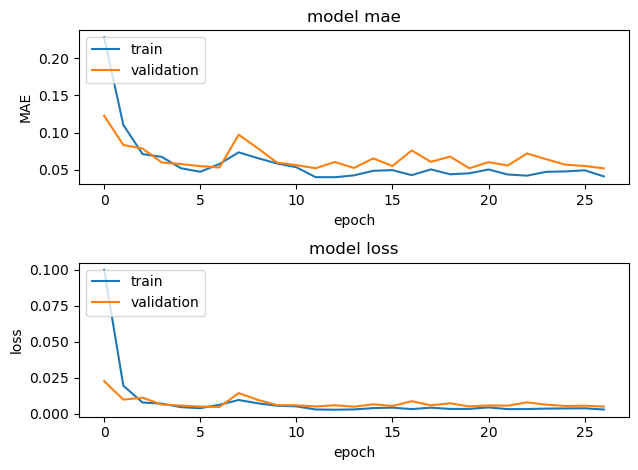

In [8]:
model = model_fit(X_train_scaled, y_train, bs=8, vs=0.2)

In [9]:
y_pred = model.predict(X_test_scaled)

print(r2_score(y_test, y_pred))

5/5 [==============================] - 0s 703us/step
0.7066576236873421


In [10]:
val_mse, val_mae = model.evaluate(X_test_scaled, y_test)

5/5 [==============================] - 0s 742us/step - loss: 0.0066 - mae: 0.0593


In [11]:
# ===================== RANDOM HYPERPARAMETER TUNING =====================
# The parameters seem to all contribute positively to admission chance. An additional hidden layer doesn't seem necessary.
# Rebuild model
def create_model(neurons=10, learning_rate=0.01):
    input_layer = layers.InputLayer(input_shape = (X_train_scaled.shape[1],))
    optimizer = Adam(learning_rate=learning_rate)
    callback = EarlyStopping(monitor='mae', mode='min', verbose=0, patience=50)
    model = Sequential()
    model.add(input_layer)
    model.add(layers.Dense(neurons, activation='relu'))  # Example input dimension
    model.add(layers.Dense(1))  # Output layer
    model.compile(Adam(lr=learning_rate), loss='mse', metrics=['mae'])
    return model


In [12]:
# Param grid
param_grid = {
    'neurons': [32, 64, 128, 256],
    'learning_rate': [0.01, 0.001, 0.0001],
    'batch_size': [2, 4, 6, 8],
    'validation_split': [0.1, 0.2, 0.3]
}

model = KerasRegressor(build_fn=create_model, verbose=0, learning_rate=0.01, neurons=32)
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=5)
grid_result = grid.fit(X_train_scaled, y_train)

/Users/andrewcheng/anaconda3/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/andrewcheng/anaconda3/lib/python3.11/site-packages/keras/src/optimizers/legacy/adam.py:118: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/Users/andrewcheng/anaconda3/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/andrewcheng/anaconda3/lib/python3.11/site-packages/keras/src/optimizers/legacy/adam.py:118: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/Users/andrewcheng/anaconda3/lib/python3.11/site-packages/scikeras/wra

In [13]:
print(grid_result.best_score_, grid_result.best_params_)

0.18862120974669766 {'batch_size': 2, 'learning_rate': 0.001, 'neurons': 256, 'validation_split': 0.1}


In [14]:
# Refined model
def model_fit(X_train_scaled, y_train):
    model = create_model(128, 0.01)
    #train the model on the training data
    callback = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 40)
    history = model.fit(X_train_scaled, y_train,
                        epochs=250,
                        batch_size= 5,
                        verbose=1,
                        validation_split = 0.2,
                        callbacks = [callback])
    val_mse, val_mae = model.evaluate(X_test_scaled, y_test)
    print(val_mse, val_mae)
    return model

In [15]:
model = model_fit(X_train_scaled, y_train)


Epoch 1/250
56/56 [==============================] - 0s 2ms/step - loss: 0.1098 - mae: 0.2526 - val_loss: 0.0211 - val_mae: 0.1136
Epoch 2/250
56/56 [==============================] - 0s 744us/step - loss: 0.0232 - mae: 0.1171 - val_loss: 0.0096 - val_mae: 0.0764
Epoch 3/250
56/56 [==============================] - 0s 717us/step - loss: 0.0065 - mae: 0.0629 - val_loss: 0.0061 - val_mae: 0.0610
Epoch 4/250
56/56 [==============================] - 0s 714us/step - loss: 0.0053 - mae: 0.0560 - val_loss: 0.0061 - val_mae: 0.0606
Epoch 5/250
56/56 [==============================] - 0s 721us/step - loss: 0.0079 - mae: 0.0666 - val_loss: 0.0049 - val_mae: 0.0533
Epoch 6/250
56/56 [==============================] - 0s 708us/step - loss: 0.0040 - mae: 0.0483 - val_loss: 0.0084 - val_mae: 0.0758
Epoch 7/250
56/56 [==============================] - 0s 718us/step - loss: 0.0048 - mae: 0.0534 - val_loss: 0.0060 - val_mae: 0.0608
Epoch 8/250
56/56 [==============================] - 0s 710us/step - lo

In [16]:
new_model_prediction = model.predict(X_test_scaled)
new_model_score = r2_score(y_test, new_model_prediction)
print(new_model_score)

5/5 [==============================] - 0s 601us/step
0.7515589663437459


In [17]:
# fig.savefig('static/images/my_plots.png')